In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

In [5]:
os.listdir('../input/animefacedataset/images')[:20]

['35715_2011.jpg',
 '48610_2014.jpg',
 '34719_2011.jpg',
 '40266_2012.jpg',
 '4199_2002.jpg',
 '40739_2013.jpg',
 '42515_2013.jpg',
 '52482_2015.jpg',
 '46555_2014.jpg',
 '11579_2005.jpg',
 '36943_2012.jpg',
 '9787_2004.jpg',
 '3388_2002.jpg',
 '8393_2004.jpg',
 '30352_2010.jpg',
 '10908_2005.jpg',
 '22363_2008.jpg',
 '51151_2015.jpg',
 '59491_2018.jpg',
 '3809_2002.jpg']

In [6]:
image_path = glob.glob('../input/animefacedataset/images/*.jpg')

In [7]:
len(image_path)

63565

In [8]:
def load_preprosess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [9]:
image_ds = tf.data.Dataset.from_tensor_slices(image_path)

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
image_ds = image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [12]:
image_ds

<ParallelMapDataset shapes: (64, 64, 3), types: tf.float32>

In [13]:
BATCH_SIZE = 128
image_count = len(image_path)

In [14]:
image_ds = image_ds.shuffle(image_count).batch(BATCH_SIZE)
image_ds = image_ds.prefetch(AUTOTUNE)

In [15]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))   
    assert model.output_shape == (None,16,16,256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None,16,16,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())             

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None,32,32,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())             

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None,64,64,3)                                            
    
    return model

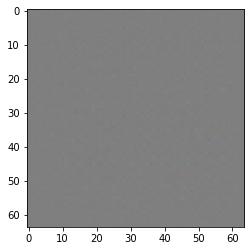

In [16]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :3] + 1)/2)

In [17]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))      # 32*32*32

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))      # 16*16*64
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))      # 16*16*64
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00135193]], shape=(1, 1), dtype=float32)


In [19]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

In [20]:
def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)  #min Ld

In [21]:
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)   #min -Lg => max Lg

In [22]:
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    for idx, grad in enumerate(gradients_of_discriminator):
        gradients_of_discriminator[idx] = tf.clip_by_value(grad, -0.01, 0.01)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1)/2)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [27]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')

In [28]:
g_loss_results = []
d_loss_results = []

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)

        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states()
        epoch_loss_avg_disc.reset_states()

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
                
        if (epoch + 1)%10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('epoch:', epoch + 1, 'g_loss:', g_loss.numpy(), 'd_loss:', d_loss.numpy())
        
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

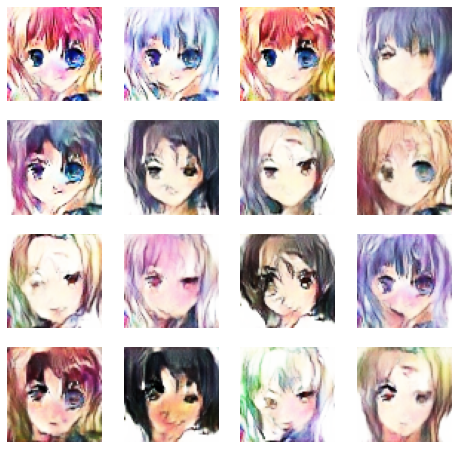

CPU times: user 1h 31min 31s, sys: 18min 38s, total: 1h 50min 10s
Wall time: 3h 33min 40s


In [30]:
%%time
train(image_ds, EPOCHS)

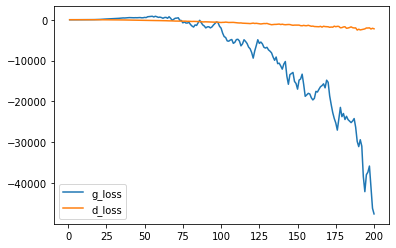

In [31]:
plt.plot(range(1, len(g_loss_results)+1), g_loss_results, label='g_loss')
plt.plot(range(1, len(d_loss_results)+1), d_loss_results, label='d_loss')
plt.legend()